In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sciStat
import sussix

import NAFFlib


---
# LHC tracking data
---

The following spectra (100 spectral lines each) are from LHC tracking data (No BB, but x-y coupling and strong 450 A arc octupoles). They accurately represent the (x-px),(y-py),(zeta-pzeta) tracjectories for 10k turns and are intended to be used as realistic example trajectories (validated manually).

In [2]:
# PARTICLES ON MOMENTUM
particles_on_p  = []
for file in ['data/LHC_particle_on_momentum_1sigma.csv',
             'data/LHC_particle_on_momentum_3sigma.csv',
             'data/LHC_particle_on_momentum_5sigma.csv']:
    
    # Loading file
    df  = pd.read_csv(file,index_col=0)
    dct = {}
    for plane in ['x','y','zeta']:  

        _df = df[[f'A{plane}',f'Q{plane}']].rename(columns={f'A{plane}':'amplitude',f'Q{plane}':'frequency'}).astype({'amplitude':np.complex128,'frequency':np.float64})

        # Recreating the signal
        nturns = int(1e4)
        z,pz = sussix.generate_signal(_df.amplitude,_df.frequency,np.arange(int(nturns)))

        # Saving the signal
        dct[f'{plane}']   = z
        dct[f'p{plane}']  = pz
        dct[f'df{plane}'] = _df
    particles_on_p.append(dct)
    

# PARTICLES OFF MOMENTUM
particles_off_p  = []
for file in ['data/LHC_particle_off_momentum_1sigma.csv',
             'data/LHC_particle_off_momentum_3sigma.csv',
             'data/LHC_particle_off_momentum_5sigma.csv']:
    
    # Loading file
    df  = pd.read_csv(file,index_col=0)
    dct = {}
    for plane in ['x','y','zeta']:  

        _df = df[[f'A{plane}',f'Q{plane}']].rename(columns={f'A{plane}':'amplitude',f'Q{plane}':'frequency'}).astype({'amplitude':np.complex128,'frequency':np.float64})

        # Recreating the signal
        nturns = int(1e4)
        z,pz = sussix.generate_signal(_df.amplitude,_df.frequency,np.arange(int(nturns)))

        # Saving the signal
        dct[f'{plane}']   = z
        dct[f'p{plane}']  = pz
        dct[f'df{plane}'] = _df
    particles_off_p.append(dct)



---
# Plotting the particles
---

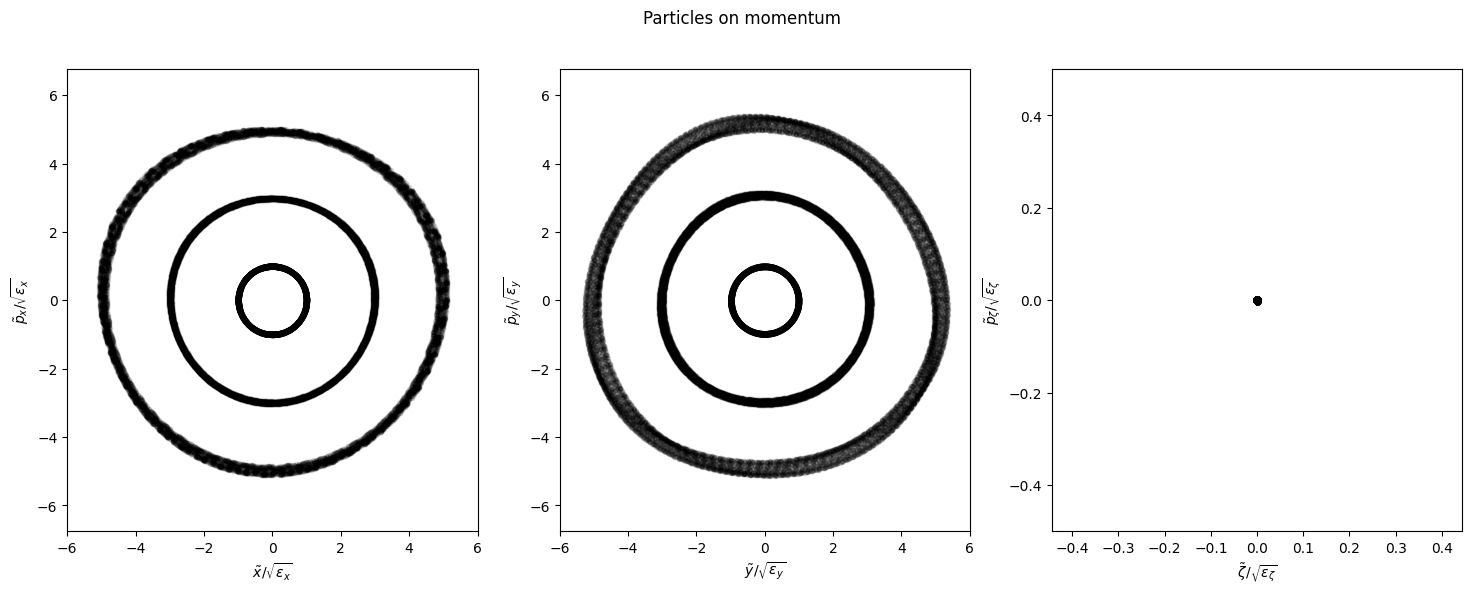

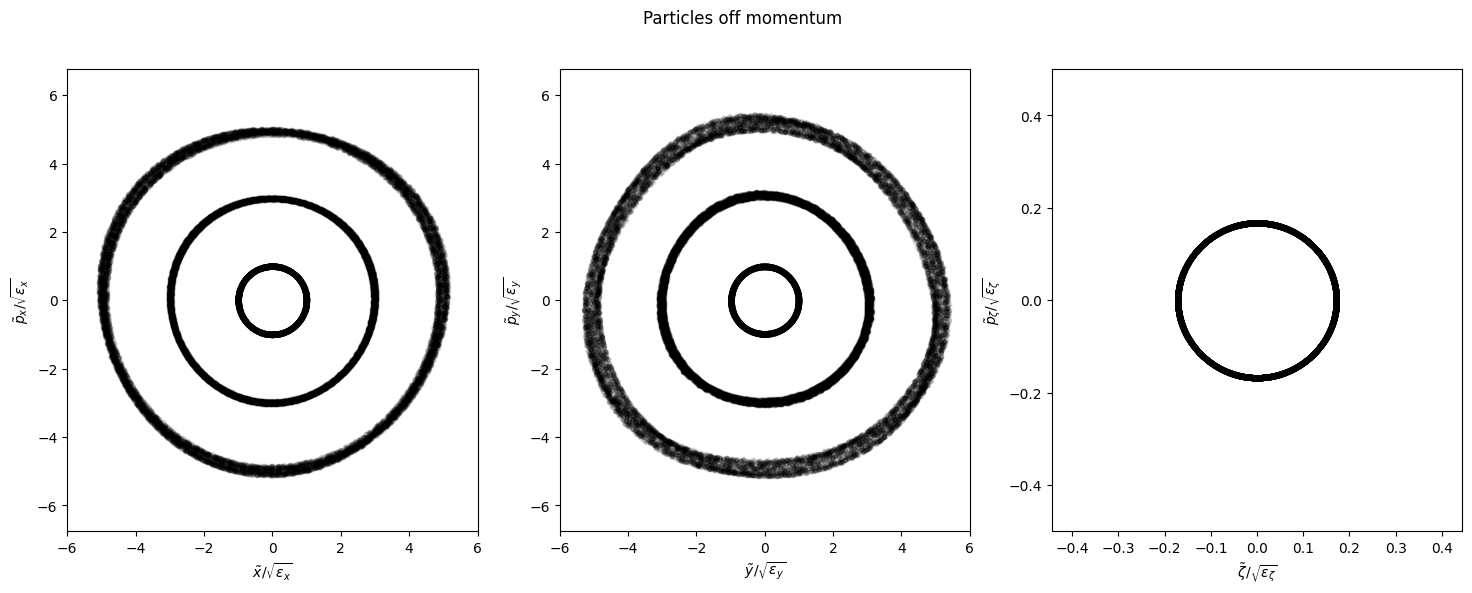

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Particles on momentum')
for part in particles_on_p:
    for plane,ax in zip(['x','y','zeta'],axes):
        plt.sca(ax)
        plt.plot(part[plane],part[f'p{plane}'],'.',color='k',alpha=0.1)

# Adding labels
for plane,ax in zip(['x','y','zeta'],axes):
    plt.sca(ax)
    plt.axis('equal')
    if plane == 'zeta':
        plane = '\zeta'
    plt.xlabel(rf'$\tilde {plane}/\sqrt{{\varepsilon_{plane}}}$')
    plt.ylabel(rf'$\tilde p_{plane}/\sqrt{{\varepsilon_{plane}}}$')
    
    if plane == '\zeta':
        plt.xlim(-0.5,0.5)
        plt.ylim(-0.5,0.5)
    else:
        plt.xlim(-6,6)
        plt.ylim(-6,6)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Particles off momentum')
for part in particles_off_p:
    for plane,ax in zip(['x','y','zeta'],axes):
        plt.sca(ax)
        plt.plot(part[plane],part[f'p{plane}'],'.',color='k',alpha=0.1)

# Adding labels
for plane,ax in zip(['x','y','zeta'],axes):
    plt.sca(ax)
    plt.axis('equal')
    if plane == 'zeta':
        plane = '\zeta'
    plt.xlabel(rf'$\tilde {plane}/\sqrt{{\varepsilon_{plane}}}$')
    plt.ylabel(rf'$\tilde p_{plane}/\sqrt{{\varepsilon_{plane}}}$')
    
    if plane == '\zeta':
        plt.xlim(-0.5,0.5)
        plt.ylim(-0.5,0.5)
    else:
        plt.xlim(-6,6)
        plt.ylim(-6,6)


---
# Extracting the tune
---

In [7]:
for part,sigma in zip(particles_on_p,[1,3,5]):
    print(40*'-')
    print(f'Particle @ {sigma} sigma:')
    print(f'x only        : {sussix.tune(part["x"],window_order=2)}')
    print(f'x-px          : {sussix.tune(part["x"],part["px"],window_order=2)}')
    print(f'NAFFlib x only: {NAFFlib.get_tune(part["x"],2)}')
    print(f'NAFFlib x-px  : {NAFFlib.get_tune(part["x"]-1j*part["px"],2)}')
    assert type(sussix.tune(part["x"],window_order=2)) == type(NAFFlib.get_tune(part["x"],2))

----------------------------------------
Particle @ 1 sigma:
x only        : 0.31002084339097
x-px          : 0.3100208433909691
NAFFlib x only: 0.3100208433731071
NAFFlib x-px  : 0.3100208433731062


AssertionError: 

In [13]:
float((sussix.tune(part["x"],window_order=2)))

0.31002084339097

In [9]:
type(NAFFlib.get_tune(part["x"],2))

float

---
# Full phase space analysis, x-plane
---

(-6.0, 6.0)

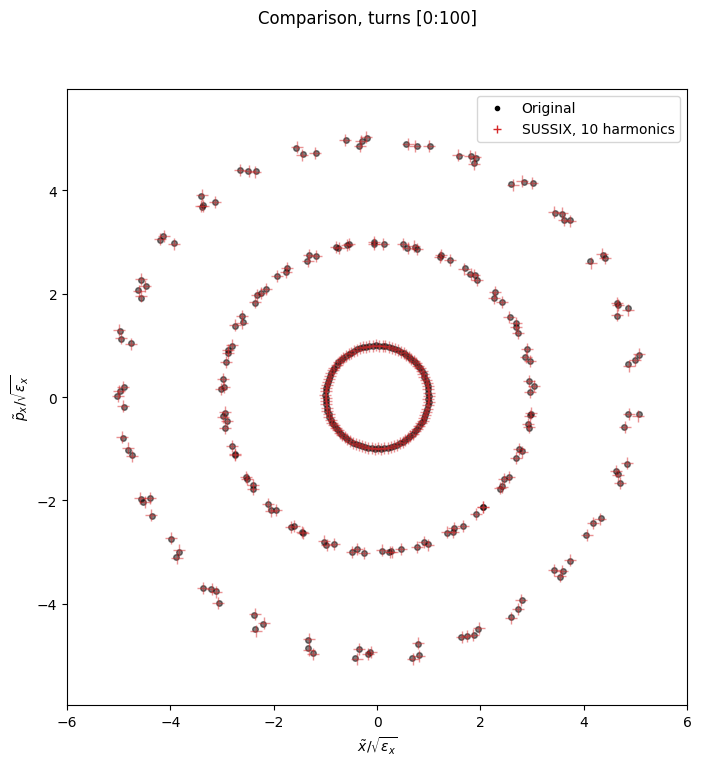

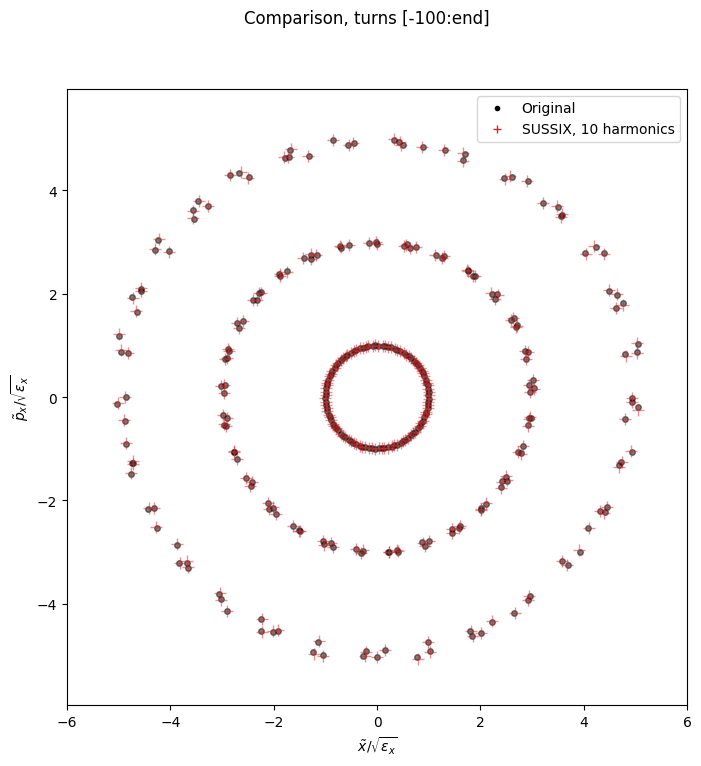

In [5]:
#-----------------------------
# PARAMETERS
n_harm = 10
nturns = 100
#-----------------------------

particles = particles_on_p

plt.figure(figsize=(8,8))
plt.suptitle(f'Comparison, turns [0:{nturns}]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r,px_r = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(part['x'][:nturns],part['px'][:nturns] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(x_r[:nturns],px_r[:nturns]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.axis('equal')
plt.xlabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')
plt.ylabel(rf'$\tilde p_x/\sqrt{{\varepsilon_x}}$')
plt.xlim(-6,6)
plt.ylim(-6,6)


plt.figure(figsize=(8,8))
plt.suptitle(f'Comparison, turns [-{nturns}:end]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r,px_r = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(part['x'][-nturns:],part['px'][-nturns:] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(x_r[-nturns:],px_r[-nturns:]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.axis('equal')
plt.xlabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')
plt.ylabel(rf'$\tilde p_x/\sqrt{{\varepsilon_x}}$')
plt.xlim(-6,6)
plt.ylim(-6,6)



---
# Position ONLY analysis
---


In [37]:
sussix.harmonics(part['x'],part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)

,amplitude,frequency
0,-0.143940-0.987097j,3.100208e-01
1,0.001111+0.007397j,3.118874e-01
2,-0.001048-0.007407j,3.081543e-01
3,-0.001244-0.003440j,3.599591e-01
4,-0.001266+0.002218j,3.799583e-01
5,-0.000972-0.001524j,-3.318658e-14
6,0.000904+0.000019j,3.699587e-01
7,-0.000477+0.000254j,-3.799583e-01
8,-0.000190+0.000376j,-3.599591e-01
9,0.000082+0.000320j,-9.999620e-03


In [39]:
sussix.harmonics(part['x']+1j*part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)

,amplitude,frequency
0,-0.143940+0.987097j,-3.100208e-01
1,0.001111-0.007397j,-3.118874e-01
2,-0.001048+0.007407j,-3.081543e-01
3,-0.001244+0.003440j,-3.599591e-01
4,-0.001266-0.002218j,-3.799583e-01
5,-0.000972+0.001524j,3.319158e-14
6,0.000904-0.000019j,-3.699587e-01
7,-0.000477-0.000254j,3.799583e-01
8,-0.000190-0.000376j,3.599591e-01
9,0.000082-0.000320j,9.999620e-03


In [5]:
spectrum = sussix.harmonics(part['x'],part['px'],num_harmonics = n_harm,window_order=2,to_pandas=True)
spectrum_df = sussix.harmonics(part['x'],num_harmonics = n_harm,window_order=2,to_pandas=True)
display(spectrum)
display(spectrum_df)

,amplitude,frequency
0,-3.378631-3.647854j,3.104867e-01
1,0.083068-0.056330j,3.588444e-01
2,-0.064821-0.009840j,3.790266e-01
3,-0.024055-0.039944j,-6.184652e-13
4,-0.014573+0.038519j,3.306688e-01
5,0.026421+0.028233j,3.123532e-01
6,-0.026115-0.028494j,3.086202e-01
7,0.005706+0.023114j,3.689355e-01
8,-0.010958-0.012447j,3.205778e-01
9,0.001571+0.013531j,-3.790266e-01


,amplitude,frequency
0,-3.374462-3.653246j,3.104867e-01
1,0.091782-0.063283j,3.588444e-01
2,-0.063250-0.023371j,3.790266e-01
3,-0.024055+0.000000j,-5.198074e-18
4,-0.015358+0.040699j,3.306688e-01
5,0.026417+0.028349j,3.123532e-01
6,-0.026056-0.028462j,3.086202e-01
7,-0.002594+0.025266j,3.689355e-01
8,-0.011029-0.011975j,3.205778e-01
9,0.007400-0.004712j,1.009106e-02


In [11]:
spectrum_x = sussix.harmonics(part['x'],num_harmonics = n_harm,window_order=2,to_pandas=False)
spectrum_x[0][0],spectrum_x[0][1],spectrum_x[1][0]

((0.04589120698586467-0.03164168861562194j),
 (0.04589120698586467-0.03164168861562194j),
 0.3588444396463075)

In [14]:
spectrum_x[1][0],spectrum_x[1][1]

((-1.6872312357485877-1.8266229959249747j),
 (-1.6872312357506627+1.8266229959226907j))

In [15]:
spectrum_x[1][0]+spectrum_x[1][1]

(-3.3744624714992506-2.283950806258872e-12j)

In [16]:
spectrum

,amplitude,frequency
0,-3.378631-3.647854j,3.104867e-01
1,0.083068-0.056330j,3.588444e-01
2,-0.064821-0.009840j,3.790266e-01
3,-0.024055-0.039944j,-6.184652e-13
4,-0.014573+0.038519j,3.306688e-01
5,0.026421+0.028233j,3.123532e-01
6,-0.026115-0.028494j,3.086202e-01
7,0.005706+0.023114j,3.689355e-01
8,-0.010958-0.012447j,3.205778e-01
9,0.001571+0.013531j,-3.790266e-01


In [19]:
np.real(spectrum.loc[0,'amplitude']),np.abs(spectrum.loc[0,'amplitude'])

(-3.378630868285527, 4.972120645181468)

array([-1.68723124-1.82662300e+00j, -1.68723124+1.82662300e+00j,
        0.04589121-3.16416886e-02j,  0.04589121+3.16416886e-02j,
       -0.03162487+1.16856237e-02j, -0.03162487-1.16856237e-02j,
       -0.02405508-2.54527950e-15j, -0.00767911+2.03493693e-02j,
       -0.00767911-2.03493693e-02j,  0.01320833+1.41742590e-02j])

In [34]:
phasors = spectrum_x[0]*np.exp(2*np.pi*1j*spectrum_x[1])
phasors

array([ 2.32219258-8.89225756e-01j,  2.32219258+8.89225756e-01j,
       -0.00446852+5.55628625e-02j, -0.00446852-5.55628625e-02j,
        0.03097201+1.33199440e-02j,  0.03097201-1.33199440e-02j,
       -0.02405508-2.54449385e-15j, -0.01406325-1.65918832e-02j,
       -0.01406325+1.65918832e-02j, -0.01814366+6.79538814e-03j])

In [39]:
phasors[0] + phasors[1:]

array([4.64438516+2.77367018e-12j, 2.31772406-8.33662894e-01j,
       2.31772406-9.44788618e-01j, 2.35316459-8.75905812e-01j,
       2.35316459-9.02545700e-01j, 2.2981375 -8.89225756e-01j,
       2.30812933-9.05817639e-01j, 2.30812933-8.72633873e-01j,
       2.30404892-8.82430368e-01j])

In [44]:
i=0
phasors[i] + phasors[i+1:]

array([4.64438516+2.77367018e-12j, 2.31772406-8.33662894e-01j,
       2.31772406-9.44788618e-01j, 2.35316459-8.75905812e-01j,
       2.35316459-9.02545700e-01j, 2.2981375 -8.89225756e-01j,
       2.30812933-9.05817639e-01j, 2.30812933-8.72633873e-01j,
       2.30404892-8.82430368e-01j])

In [43]:
phasors[i] + phasors[i+1:]

array([-0.03220691+0.02338727j])

In [51]:
spectrum_df

,amplitude,frequency
0,-1.687231-1.826623j,3.104867e-01
1,-1.687231+1.826623j,-3.104867e-01
2,0.045891-0.031642j,3.588444e-01
3,0.045891+0.031642j,-3.588444e-01
4,-0.031625+0.011686j,-3.790266e-01
5,-0.031625-0.011686j,3.790266e-01
6,-0.024055-0.000000j,-5.198074e-18
7,-0.007679+0.020349j,3.306688e-01
8,-0.007679-0.020349j,-3.306688e-01
9,0.013208+0.014174j,3.123532e-01


In [63]:
A

array([-1.68723124-1.82662300e+00j, -1.68723124+1.82662300e+00j,
        0.04589121-3.16416886e-02j,  0.04589121+3.16416886e-02j,
       -0.03162487+1.16856237e-02j, -0.03162487-1.16856237e-02j,
       -0.02405508-2.54527950e-15j, -0.00767911+2.03493693e-02j,
       -0.00767911-2.03493693e-02j,  0.01320833+1.41742590e-02j])

In [12]:
sussix.naff

<function sussix.naff.naff(z, num_harmonics=1, window_order=1, window_type='hann', to_pandas=False)>

In [75]:
z = part['x'] - 0*1j*part['px']
n_harm = 9
amplitudes,frequencies = sussix.naff(z, num_harmonics = 2*n_harm,
                                        window_order = 1,)

A,Q = amplitudes,frequencies
phasors = A*np.exp(2*np.pi*1j*Q)

freq = []
amp  = []

for i in range(len(Q)-2):
    comparisons = phasors[i] + phasors
    pair_idx = np.argmin(np.abs(np.imag(comparisons)))

    pair_A = np.array([A[i],A[pair_idx]])
    pair_Q = np.array([Q[i],Q[pair_idx]])

    if np.abs(np.diff(np.abs(pair_Q)))[0]>1e-10:
        freq.append(Q[i])
        amp.append(A[i])
        continue

    real = np.mean(np.real(pair_A))
    imag = np.mean(np.abs(np.imag(pair_A)))
    sign = np.sign(np.imag(pair_A))[pair_Q>=0]

    if pair_Q[0]==pair_Q[1]:
        # No complex conjugate found
        freq.append(pair_Q[0])
        amp.append(real+1j*imag)
        # print('Test')
    else:
        # Complex conjugate found
        if np.mean(np.abs(pair_Q)) not in freq:
            
            freq.append(np.mean(np.abs(pair_Q)))
            amp.append(real+sign[0]*1j*imag)

pd.DataFrame({'amplitude':amp,'frequency':freq})

Test


,amplitude,frequency
0,-1.687227-1.826627j,3.104867e-01
1,0.045891-0.031642j,3.588444e-01
2,-0.031625-0.011685j,3.790266e-01
3,-0.024055+0.000000j,1.457200e-19
4,-0.007679+0.020349j,3.306688e-01
5,0.013209+0.014174j,3.123532e-01
6,-0.013028-0.014231j,3.086202e-01
7,-0.001297+0.012633j,3.689355e-01
8,-0.005514-0.005988j,3.205778e-01


array([ 3.10486717e-01, -3.10486717e-01,  3.58844440e-01, -3.58844440e-01,
        3.79026567e-01, -3.79026567e-01,  1.45720047e-19, -3.30668844e-01,
        3.30668844e-01, -3.12353228e-01,  3.12353228e-01, -3.08620202e-01,
        3.08620202e-01, -3.68935503e-01,  3.68935503e-01,  3.20577780e-01,
       -3.20577780e-01, -1.00910635e-02,  1.00910635e-02, -3.00395655e-01,
        3.00395655e-01, -6.85398501e-02,  6.85398501e-02, -2.90304579e-01,
        2.90304579e-01,  4.83577231e-02, -4.83577231e-02,  2.72220057e-01,
       -2.72220057e-01, -3.48753379e-01,  3.48753379e-01, -3.60710972e-01,
        3.60710972e-01, -3.56977917e-01,  3.56977917e-01,  2.41946866e-01,
       -2.41946866e-01, -3.77160082e-01,  3.77160082e-01,  3.80893082e-01])

In [24]:
freq

[0.31048671661696814,
 0.3588444397364695,
 0.3790265667460358,
 -1.5325367070376888e-17,
 0.3306688435668992,
 0.312353228429603,
 0.3086202017840425,
 0.36893550328308916,
 0.3205777801241907,
 0.010091063513793488]

In [18]:
A

array([-3.37862310e+00-3.64786097e+00j,  8.30675646e-02-5.63298838e-02j,
       -6.48206235e-02-9.83974017e-03j, -2.40550809e-02-3.99438662e-02j,
       -1.45733339e-02+3.85193844e-02j,  2.64217649e-02+2.82328611e-02j,
       -2.61149420e-02-2.84941711e-02j,  5.70569212e-03+2.31142348e-02j,
       -1.09584519e-02-1.24466401e-02j,  1.57076605e-03+1.35312408e-02j,
        8.71459092e-03+6.95385958e-03j, -8.29999621e-03-2.15173208e-03j,
        1.41290624e-03+8.33434714e-03j,  5.98757488e-03+3.62263547e-03j,
        4.16839120e-03+5.39221904e-03j,  5.20271620e-03-8.44007723e-04j,
       -3.14005505e-03-2.78334113e-03j, -3.20479188e-03+8.80530122e-04j,
       -2.85624776e-03-2.64478095e-03j,  1.88008732e-03+1.53482402e-03j])

In [89]:

frequencies

[0.31048671666610894,
 0.3588444396463075,
 0.37902656665183193,
 -5.198074358820021e-18,
 0.3306688436014944]

In [59]:
np.argmin([harmonics[i],harmonics[pair_idx]])

IndexError: tuple index out of range

In [56]:
harmonics[1]

array([ 3.10486717e-01, -3.10486717e-01,  3.58844440e-01, -3.58844440e-01,
       -3.79026567e-01,  3.79026567e-01, -5.19807436e-18,  3.30668844e-01,
       -3.30668844e-01,  3.12353228e-01])

In [27]:
list(spectrum_x)[0]

array([-1.68723124-1.82662300e+00j, -1.68723124+1.82662300e+00j,
        0.04589121-3.16416886e-02j,  0.04589121+3.16416886e-02j,
       -0.03162487+1.16856237e-02j, -0.03162487-1.16856237e-02j,
       -0.02405508-2.54527950e-15j, -0.00767911+2.03493693e-02j,
       -0.00767911-2.03493693e-02j,  0.01320833+1.41742590e-02j])

In [21]:
np.abs(spectrum_x[0][1])+np.abs(spectrum_x[0][0])

4.973248761977211

(-6.0, 6.0)

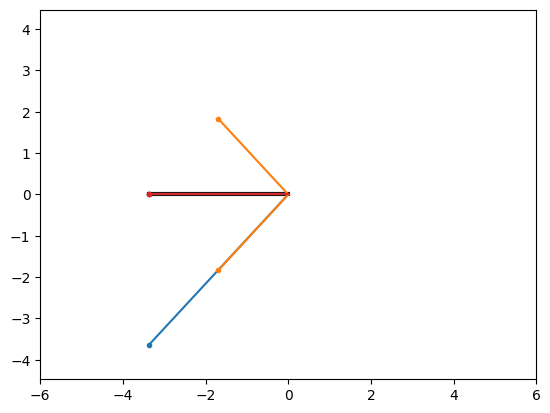

In [17]:
def plotvec(z,**kwargs):
    x,px = z.real,z.imag
    plt.plot([0,x],[0,px],'-',**kwargs)
    plt.plot(x,px,'.',**kwargs)


plt.figure()
plotvec(spectrum.loc[0,'amplitude'],color='C0')
plotvec(spectrum_x[0][0],color='C1')
plotvec(spectrum_x[0][1],color='C1')
plotvec(spectrum_x[0][1]+spectrum_x[0][0],color='C3')
plotvec(np.real(spectrum.loc[0,'amplitude']),color='k',alpha=0.9,lw=3,zorder=-10)

plt.axis('equal')
plt.xlim(-6,6)
plt.ylim(-6,6)  


Text(0, 0.5, '$\\tilde x/\\sqrt{\\varepsilon_x}$')

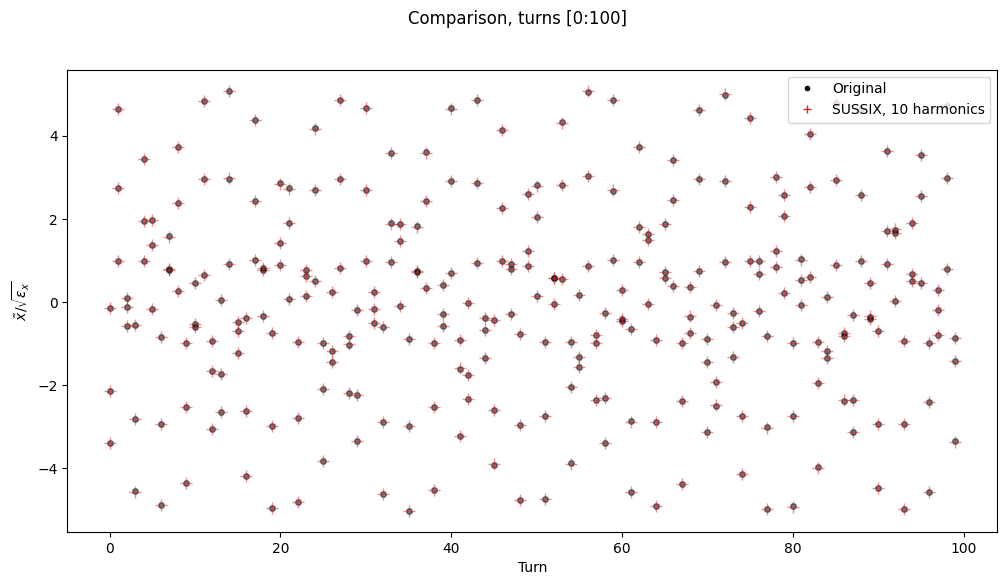

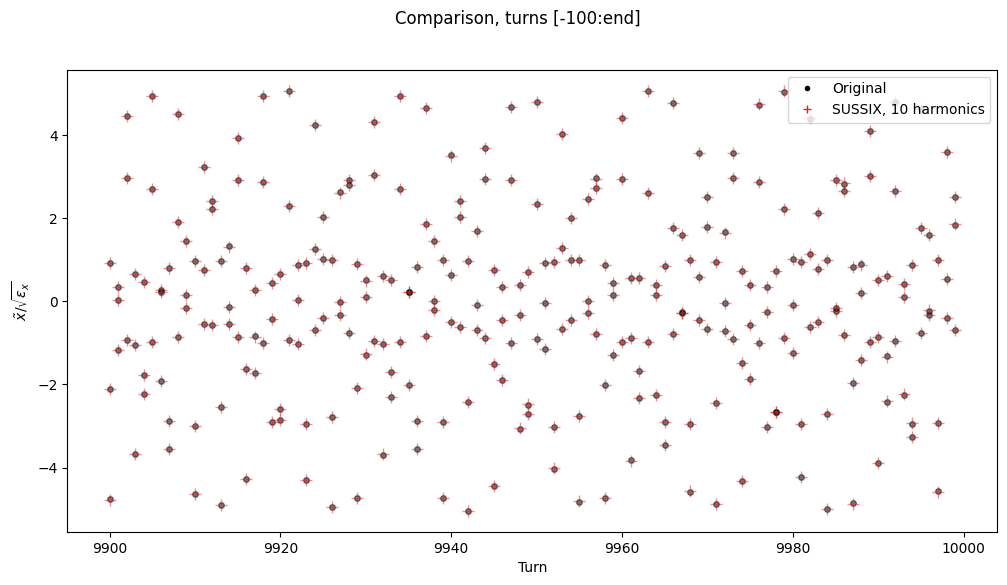

In [6]:
particles = particles_on_p

plt.figure(figsize=(12,6))
plt.suptitle(f'Comparison, turns [0:{nturns}]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r, _   = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(np.arange(0,nturns),part['x'][:nturns] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(np.arange(0,nturns),x_r[:nturns]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.xlabel(rf'Turn')
plt.ylabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')


plt.figure(figsize=(12,6))
plt.suptitle(f'Comparison, turns [-{nturns}:end]')
for part in particles:
    spectrum = sussix.harmonics(part['x'],num_harmonics = n_harm,window_order=2,to_pandas=True)
    x_r, _   = sussix.generate_signal(spectrum.amplitude,spectrum.frequency,np.arange(len(part['x'])))

    plt.plot(np.arange(int(1e4-nturns),int(1e4)),part['x'][-nturns:] ,'.',ms=8,color='k'  ,alpha=0.5)
    plt.plot(np.arange(int(1e4-nturns),int(1e4)),x_r[-nturns:]             ,'+',ms=8,color='C3' ,alpha=0.5)

plt.plot(np.nan,np.nan,'.',color='k' ,label='Original')
plt.plot(np.nan,np.nan,'+',color='C3',label=f'SUSSIX, {n_harm} harmonics')
plt.legend()
plt.xlabel(rf'Turn')
plt.ylabel(rf'$\tilde x/\sqrt{{\varepsilon_x}}$')


---
# Spectrum comparison
---

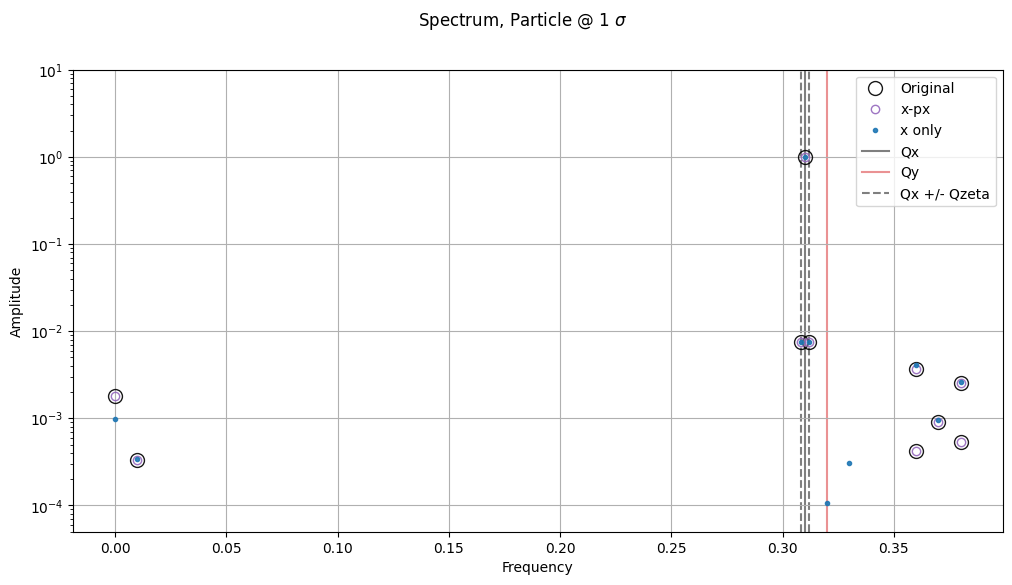

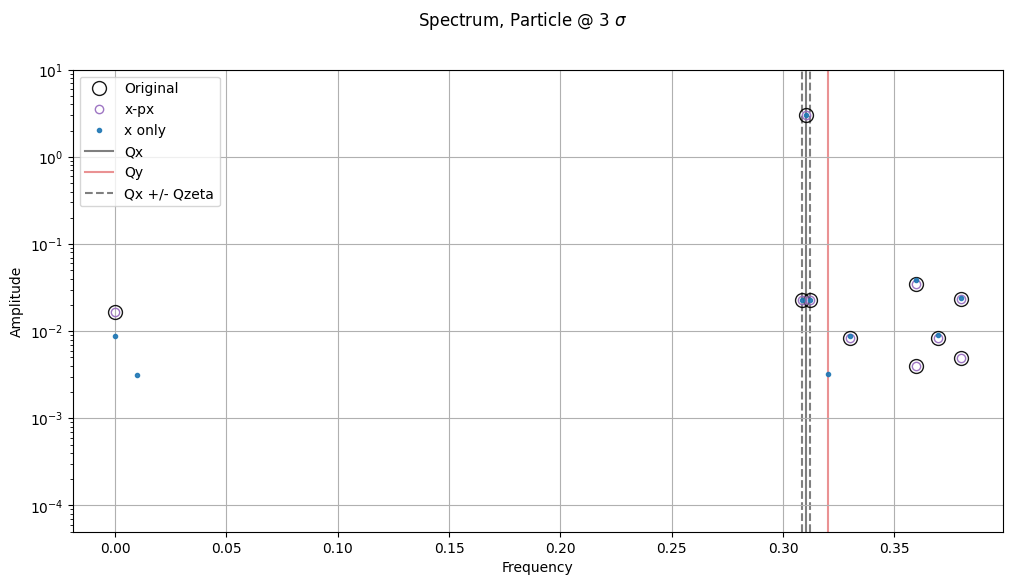

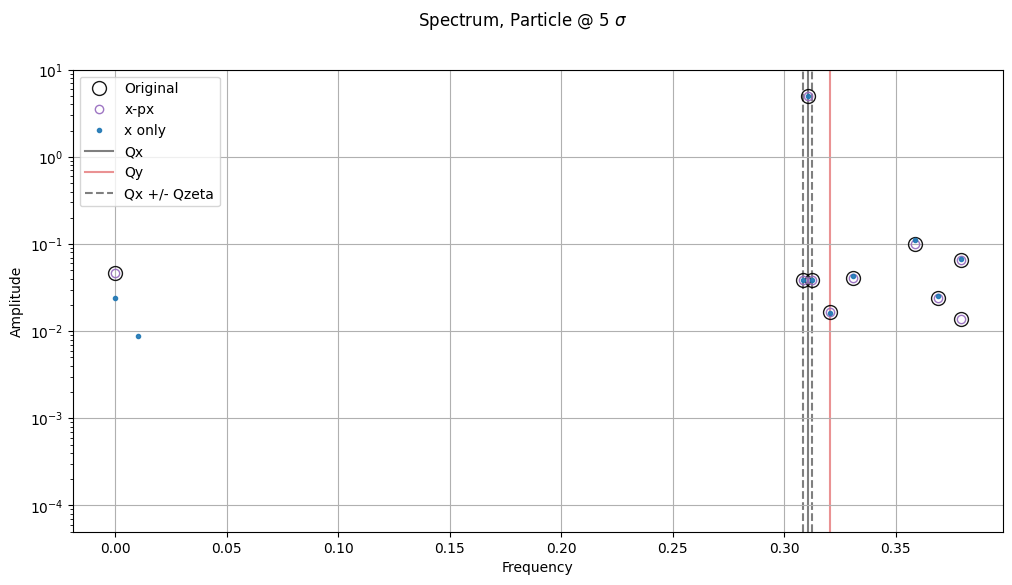

In [7]:
particles = particles_on_p
for part,sigma in zip(particles,[1,3,5]):
    plt.figure(figsize=(12,6))
    plt.suptitle(f'Spectrum, Particle @ {sigma} $\sigma$')
    spectrum_x    = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    spectrum_x_px = sussix.harmonics(part['x'],part['px'],  num_harmonics = n_harm,window_order=2,to_pandas=True)

    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    plt.plot( np.abs(part['dfx'].frequency[:n_harm]),np.abs(part['dfx'].amplitude[:n_harm]),'o',ms=10,mfc='none',   color='black' ,alpha=0.9,label='Original')
    plt.plot( np.abs(spectrum_x_px.frequency),np.abs(spectrum_x_px.amplitude),'o',mfc='none',   color='C4' ,alpha=0.9,label='x-px')
    plt.plot( np.abs(spectrum_x.frequency)   ,np.abs(spectrum_x.amplitude),'.'   ,                    color='C0' ,alpha=0.9,label='x only')

    plt.axvline(fundamental_tunes[0],color='k',label='Qx',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[1],color='C3',label='Qy',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]+fundamental_tunes[2],ls='--',color='k',label='Qx +/- Qzeta',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]-fundamental_tunes[2],ls='--',color='k',zorder = -100,alpha=0.5)

    plt.legend()
    plt.yscale('log')
    plt.ylim(5e-5,1e1)
    plt.grid()
    plt.xlabel(rf'Frequency')
    plt.ylabel(rf'Amplitude')
    

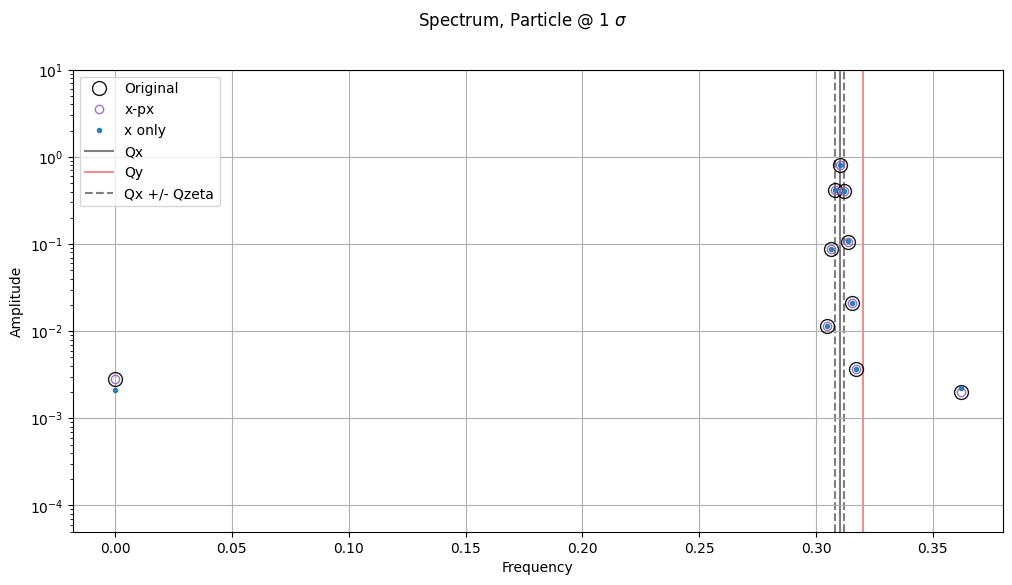

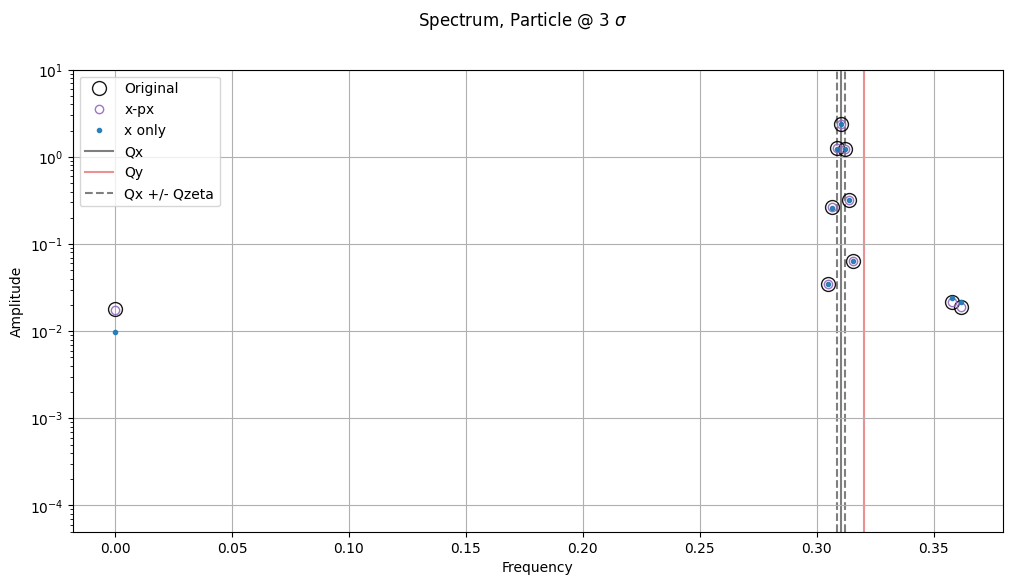

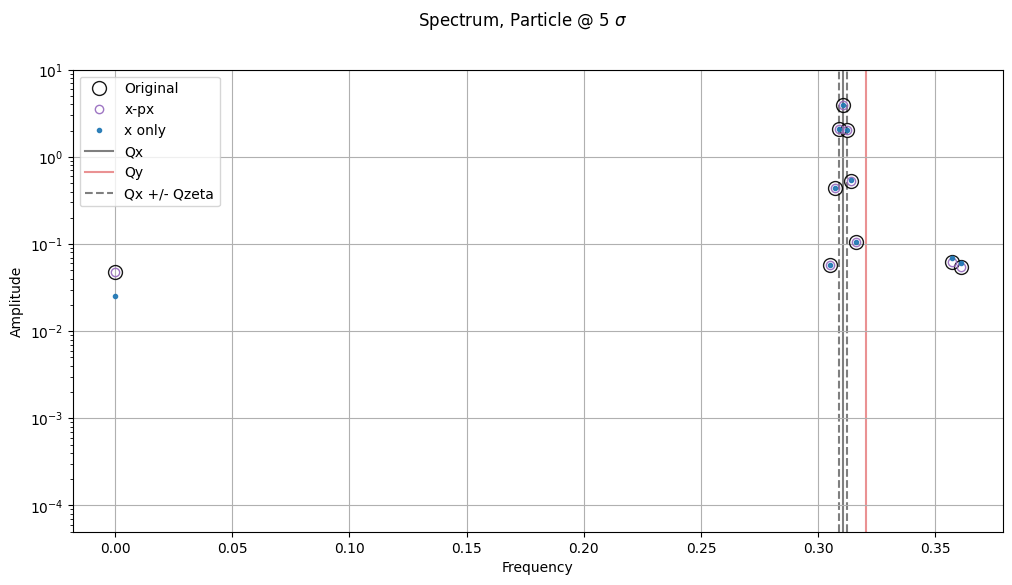

In [9]:
particles = particles_off_p
for part,sigma in zip(particles,[1,3,5]):
    plt.figure(figsize=(12,6))
    plt.suptitle(f'Spectrum, Particle @ {sigma} $\sigma$')
    spectrum_x    = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    spectrum_x_px = sussix.harmonics(part['x'],part['px'],  num_harmonics = n_harm,window_order=2,to_pandas=True)

    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    plt.plot( np.abs(part['dfx'].frequency[:n_harm]),np.abs(part['dfx'].amplitude[:n_harm]),'o',ms=10,mfc='none',   color='black' ,alpha=0.9,label='Original')
    plt.plot( np.abs(spectrum_x_px.frequency),np.abs(spectrum_x_px.amplitude),'o',mfc='none',   color='C4' ,alpha=0.9,label='x-px')
    plt.plot( np.abs(spectrum_x.frequency)   ,np.abs(spectrum_x.amplitude),'.'   ,                    color='C0' ,alpha=0.9,label='x only')

    plt.axvline(fundamental_tunes[0],color='k',label='Qx',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[1],color='C3',label='Qy',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]+fundamental_tunes[2],ls='--',color='k',label='Qx +/- Qzeta',zorder = -100,alpha=0.5)
    plt.axvline(fundamental_tunes[0]-fundamental_tunes[2],ls='--',color='k',zorder = -100,alpha=0.5)

    plt.legend()
    plt.yscale('log')
    plt.ylim(5e-5,1e1)
    plt.grid()
    plt.xlabel(rf'Frequency')
    plt.ylabel(rf'Amplitude')
    

---
# Frequencies as linear combinations?
---

In [13]:
particles = particles_on_p

for part in particles:
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]
    spectrum_x        = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    combination_jklm  = sussix.find_linear_combinations(spectrum_x.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10,to_pandas=True)
    display(combination_jklm)

,jklm,err,freq
0,"(1, 0, 0, 0)",8.326673e-16,3.100208e-01
1,"(1, 0, 1, 0)",4.788447e-12,3.118874e-01
2,"(1, 0, -1, 0)",1.497802e-12,3.081543e-01
3,"(0, -2, 0, 1)",7.494005e-14,3.599591e-01
4,"(-2, 0, 0, 1)",9.414691e-14,3.799583e-01
5,"(0, 0, 0, 0)",3.398890e-18,3.398890e-18
6,"(-1, -1, 0, 1)",9.553469e-14,3.699587e-01
7,"(-1, 1, 0, 0)",1.477984e-15,9.999620e-03
8,"(-1, 2, 0, 0)",3.844258e-12,3.300201e-01
9,"(0, 1, 0, 0)",1.812445e-11,3.200205e-01


,jklm,err,freq
0,"(1, 0, 0, 0)",8.881784e-16,3.101772e-01
1,"(0, -2, 0, 1)",7.321921e-14,3.595955e-01
2,"(-2, 0, 0, 1)",9.436896e-14,3.796455e-01
3,"(1, 0, 1, 0)",4.436063e-12,3.120438e-01
4,"(1, 0, -1, 0)",1.939837e-12,3.083107e-01
5,"(0, 0, 0, 0)",5.650273e-18,-5.650273e-18
6,"(-1, -1, 0, 1)",6.539214e-14,3.696205e-01
7,"(-1, 2, 0, 0)",1.026734e-12,3.302273e-01
8,"(0, 1, 0, 0)",2.034206e-12,3.202023e-01
9,"(-1, 1, 0, 0)",2.678413e-15,1.002501e-02


,jklm,err,freq
0,"(1, 0, 0, 0)",2.220446e-15,3.104867e-01
1,"(0, -2, 0, 1)",1.451173e-12,3.588444e-01
2,"(-2, 0, 0, 1)",1.595463e-11,3.790266e-01
3,"(0, 0, 0, 0)",5.198074e-18,-5.198074e-18
4,"(-1, 2, 0, 0)",8.754253e-11,3.306688e-01
5,"(1, 0, 1, 0)",6.944187e-09,3.123532e-01
6,"(1, 0, -1, 0)",3.491632e-09,3.086202e-01
7,"(-1, -1, 0, 1)",1.324779e-11,3.689355e-01
8,"(0, 1, 0, 0)",3.100636e-11,3.205778e-01
9,"(-1, 1, 0, 0)",8.023426e-13,1.009106e-02


In [14]:
particles = particles_off_p

for part in particles:
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]
    spectrum_x        = sussix.harmonics(part['x'],             num_harmonics = n_harm,window_order=2,to_pandas=True)
    combination_jklm  = sussix.find_linear_combinations(spectrum_x.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10,to_pandas=True)
    display(combination_jklm)

,jklm,err,freq
0,"(1, 0, 0, 0)",2.034484e-13,3.101051e-01
1,"(1, 0, 1, 0)",5.032585e-12,3.119052e-01
2,"(1, 0, -1, 0)",1.388145e-11,3.083051e-01
3,"(1, 0, 2, 0)",2.177553e-11,3.137052e-01
4,"(1, 0, -2, 0)",1.464484e-11,3.065050e-01
5,"(1, 0, 3, 0)",1.353970e-10,3.155053e-01
6,"(1, 0, -3, 0)",1.856132e-11,3.047049e-01
7,"(0, 0, 0, 0)",4.549661e-18,4.549661e-18
8,"(1, 0, 4, 0)",2.367635e-09,3.173054e-01
9,"(0, -2, 1, 1)",2.759081e-10,3.618182e-01


,jklm,err,freq
0,"(1, 0, 0, 0)",2.040035e-13,3.102616e-01
1,"(1, 0, -1, 0)",2.996869e-11,3.084616e-01
2,"(1, 0, 1, 0)",1.251438e-11,3.120617e-01
3,"(1, 0, 2, 0)",3.256601e-11,3.138617e-01
4,"(1, 0, -2, 0)",1.451378e-11,3.066615e-01
5,"(1, 0, 3, 0)",3.073184e-10,3.156618e-01
6,"(1, 0, -3, 0)",1.278688e-11,3.048614e-01
7,"(0, -2, 1, 1)",2.819278e-11,3.614535e-01
8,"(0, -2, -1, 1)",2.389744e-11,3.578534e-01
9,"(0, 0, 0, 0)",5.127754e-19,-5.127754e-19


,jklm,err,freq
0,"(1, 0, 0, 0)",1.751377e-13,3.105712e-01
1,"(1, 0, 1, 0)",4.033002e-11,3.123712e-01
2,"(1, 0, -1, 0)",6.385448e-13,3.087711e-01
3,"(1, 0, 2, 0)",3.409734e-11,3.141712e-01
4,"(1, 0, -2, 0)",1.885535e-10,3.069711e-01
5,"(1, 0, 3, 0)",1.012895e-09,3.159713e-01
6,"(0, -2, -1, 1)",1.410213e-10,3.570992e-01
7,"(0, -2, 1, 1)",5.265099e-10,3.606992e-01
8,"(1, 0, -3, 0)",1.049589e-10,3.051711e-01
9,"(0, 0, 0, 0)",2.238375e-17,2.238375e-17


---
# Convergence
---

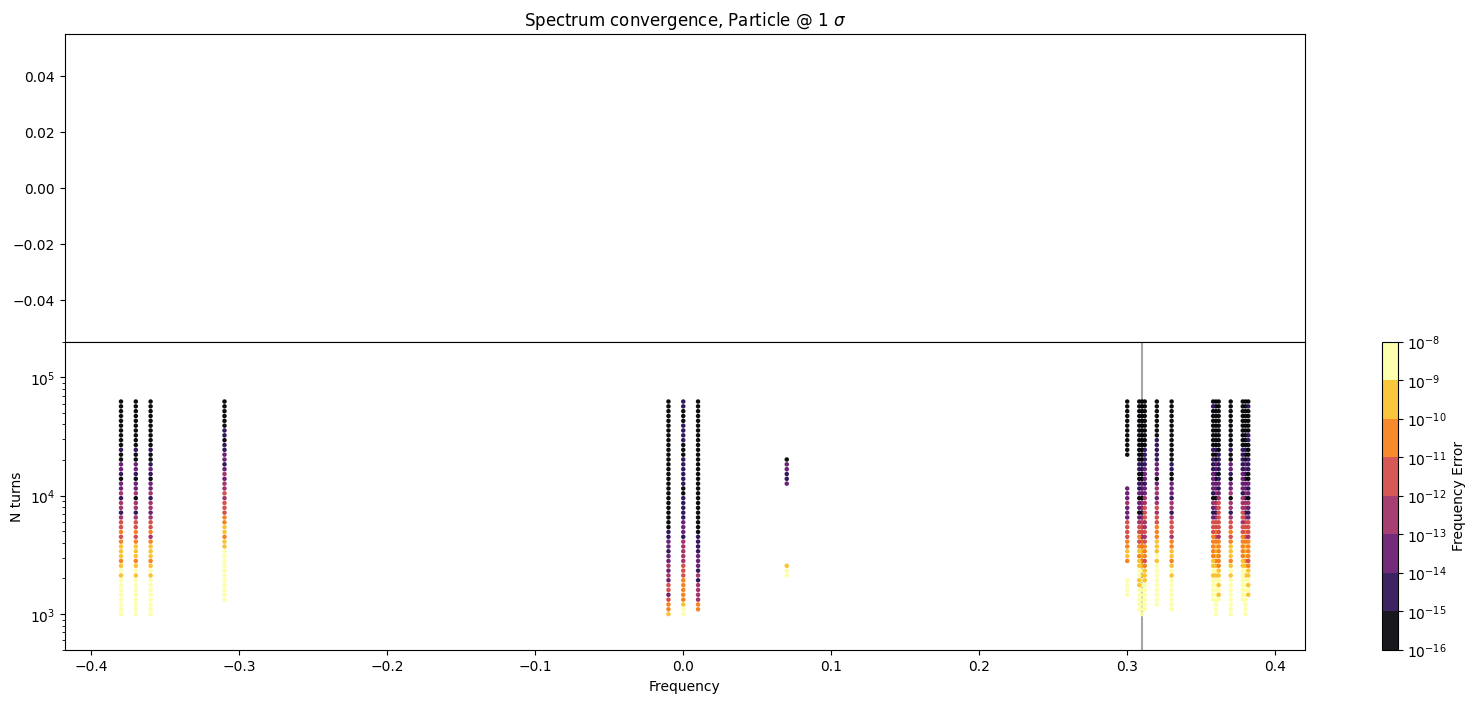

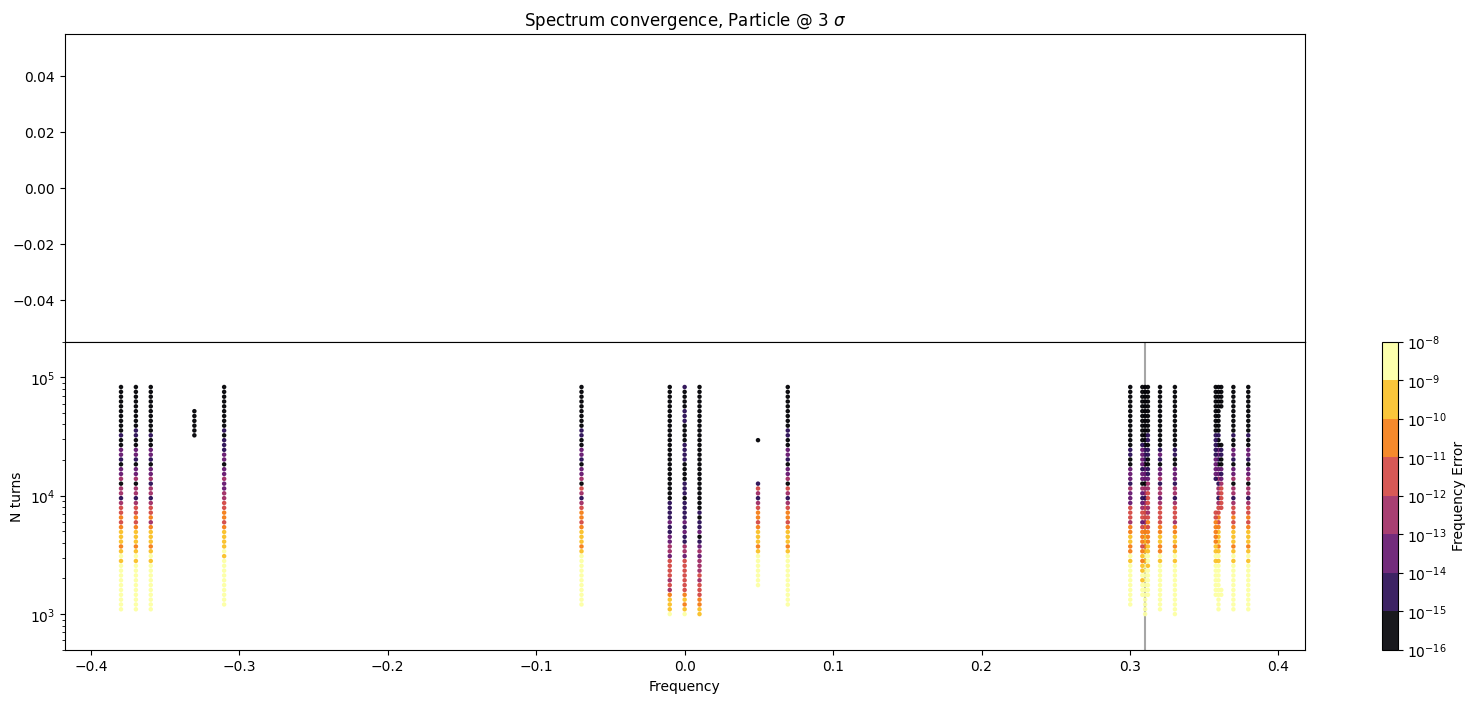

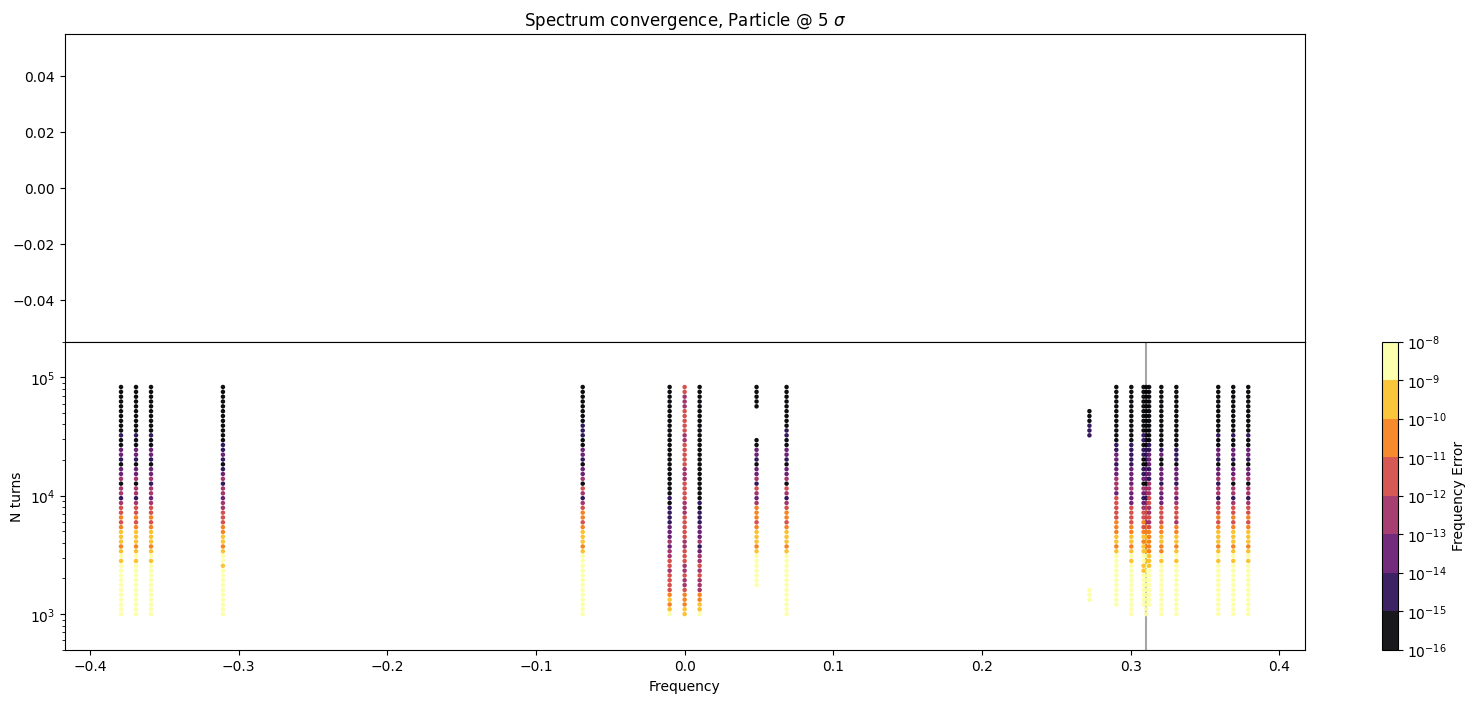

In [49]:

import matplotlib.colors as colors

n_harm = 20
cmap_name = 'inferno'

# Since the signal is artificially generated from a sum of phasors, let's look beyond the nturn = 1e4 limit and see if we can find the expected frequencies.
plane     = 'x'
particles = particles_on_p

for part,sigma in zip(particles,[1,3,5]):

    x,px = sussix.generate_signal(part[f'df{plane}'].amplitude,part[f'df{plane}'].frequency,np.arange(int(1e6)))
    expected = part[f'df{plane}'][:2*n_harm]
    fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

    # Trying to identify line based on jklm
    #---------------------------------------
    combination_jklm  = sussix.find_linear_combinations(expected.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10,to_pandas=True)
    if not len(combination_jklm.jklm.unique()) == 2*n_harm:
        continue

    # setting jklm as index
    expected.insert(0,'jklm',combination_jklm.jklm)
    expected.set_index('jklm',inplace=True)
    #---------------------------------------

    N_vec = np.logspace(3,5,50).astype(int)

    results = []
    for N in N_vec:
        spectrum = sussix.harmonics(x[:N], px[:N], num_harmonics = n_harm,window_order=2,to_pandas=True)

        # Trying to identify line based on jklm
        #---------------------------------------
        combination_jklm  = sussix.find_linear_combinations(spectrum.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10,to_pandas=True)
        if not len(combination_jklm.jklm.unique()) == n_harm:
            continue

        # setting jklm as index
        spectrum.insert(0,'jklm',combination_jklm.jklm)
        spectrum.set_index('jklm',inplace=True)
        #---------------------------------------

        # Computing error
        #---------------------------------------
        spectrum.insert(1,'Err:A',np.abs(spectrum.amplitude.abs() - expected.amplitude.abs()))
        spectrum.insert(2,'Err:Q',np.abs(spectrum.frequency - expected.frequency))
        spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21
        #---------------------------------------

        results.append(spectrum)


    # PLOTTING
    fig, axs = plt.subplots(2, 1,figsize=(20,8))
    plt.subplots_adjust(hspace=0)
    axs[0].set_title(f'Spectrum convergence, Particle @ {sigma} $\sigma$')

    # Bottom plot
    #-----------------------------
    plt.sca(axs[1])
    bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    

    for N,spectrum in zip(N_vec,results):
        plt.scatter(spectrum.frequency,N*np.ones(len(spectrum)),c=spectrum['Err:Q'],s=5,alpha=0.9,norm=norm,cmap=cmap_name )
        # if len(spectrum) != len(spectrum.dropna()):
            # display(spectrum)

    cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
    cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

    plt.axvline(fundamental_tunes[0],color='grey',alpha=0.7,zorder=-10)
    plt.yscale('log')
    plt.ylim(np.min(N_vec)/2,np.max(N_vec)*2)
    plt.xlabel('Frequency')
    plt.ylabel('N turns')
    #-----------------------------

    # plt.xlim([-0.1,0.1])


    plt.sca(axs[0])
    # plt.plot(expected.frequency,np.abs(expected.amplitude),'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
    # plt.plot(results.frequency,np.abs(results.amplitude),'.',color='k',alpha=0.8,ms=3,label='SUSSIX')
    plt.scatter(np.nan,np.nan)
    cbar = plt.colorbar()
    cbar.ax.set_visible(False)
    plt.xticks([])



In [19]:
expected

,amplitude,frequency
jklm,,
"(1, 0, 0, 0)",-0.143940-0.987097j,3.100208e-01
"(1, 0, 1, 0)",0.001111+0.007397j,3.118874e-01
"(1, 0, -1, 0)",-0.001048-0.007407j,3.081543e-01
"(0, -2, 0, 1)",-0.001244-0.003440j,3.599591e-01
"(-2, 0, 0, 1)",-0.001266+0.002218j,3.799583e-01
"(0, 0, 0, 0)",-0.000972-0.001524j,-1.807391e-14
"(-1, -1, 0, 1)",0.000904+0.000019j,3.699587e-01
"(2, 0, 0, -1)",-0.000477+0.000254j,-3.799583e-01
"(0, 2, 0, -1)",-0.000190+0.000376j,-3.599591e-01


In [20]:
spectrum

,amplitude,Err:A,Err:Q,frequency
jklm,,,,
"(1, 0, 0, 0)",-0.143940-0.987097j,4.639622e-13,1.000000e-21,3.100208e-01
"(1, 0, 1, 0)",0.001111+0.007397j,7.533037e-15,2.775558e-16,3.118874e-01
"(1, 0, -1, 0)",-0.001048-0.007407j,1.693611e-14,1.000000e-21,3.081543e-01
"(0, -2, 0, 1)",-0.001244-0.003440j,1.165300e-15,1.000000e-21,3.599591e-01
"(-2, 0, 0, 1)",-0.001266+0.002218j,5.850355e-16,2.775558e-16,3.799583e-01
"(0, 0, 0, 0)",-0.000972-0.001524j,5.854692e-18,1.291895e-15,-1.936581e-14
"(-1, -1, 0, 1)",0.000904+0.000019j,2.544731e-15,5.551115e-17,3.699587e-01
"(2, 0, 0, -1)",-0.000477+0.000254j,1.820375e-16,2.775558e-16,-3.799583e-01
"(0, 2, 0, -1)",-0.000190+0.000376j,8.451356e-17,1.000000e-21,-3.599591e-01


In [15]:
x,px = sussix.generate_signal(part[f'df{plane}'].amplitude,part[f'df{plane}'].frequency,np.arange(int(1e5)))
expected = part[f'df{plane}'][:2*n_harm]
fundamental_tunes = [sussix.tune(part[f'{plane}'],part[f'p{plane}'],window_order=2) for plane in ['x','y','zeta']]

# Trying to identify line based on jklm
#---------------------------------------
combination_jklm  = sussix.find_linear_combinations(expected.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10,to_pandas=True)
# if not len(combination_jklm.jklm.unique()) == n_harm:
    # continue

In [16]:
len(combination_jklm.jklm.unique()),2*n_harm

(20, 20)

In [ ]:
combination_jklm.jklm

In [20]:
combination_jklm

,jklm,err,freq
0,"(1, 0, 0, 0)",9.383050e-13,3.100208e-01
1,"(1, 0, 1, 0)",3.311240e-12,3.118874e-01
2,"(1, 0, -1, 0)",1.700529e-12,3.081543e-01
3,"(0, -2, 0, 1)",1.915912e-12,3.599591e-01
4,"(-2, 0, 0, 1)",1.937839e-12,3.799583e-01
5,"(0, 0, 0, 0)",0.000000e+00,0.000000e+00
6,"(-1, -1, 0, 1)",1.855904e-12,3.699587e-01
7,"(2, 0, 0, -1)",1.878553e-12,-3.799583e-01
8,"(0, 2, 0, -1)",1.947609e-12,-3.599591e-01
9,"(1, -1, 0, 0)",6.461845e-15,-9.999620e-03


In [33]:
for N in [int(6e4)]:
    spectrum = sussix.harmonics(x[:N], px[:N], num_harmonics = n_harm,window_order=2,to_pandas=True)

    # Trying to identify line based on jklm
    #---------------------------------------
    combination_jklm  = sussix.find_linear_combinations(spectrum.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10,to_pandas=True)
    if not len(combination_jklm.jklm.unique()) == n_harm:
        continue

    # setting jklm as index
    spectrum.insert(0,'jklm',combination_jklm.jklm)
    spectrum.set_index('jklm',inplace=True)
    #---------------------------------------

    # Computing error
    #---------------------------------------
    spectrum.insert(1,'Err:A',np.abs(spectrum.amplitude.abs() - expected.amplitude.abs()))
    spectrum.insert(2,'Err:Q',np.abs(spectrum.frequency - expected.frequency))
    spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21
    #---------------------------------------

In [32]:
spectrum

,amplitude,Err:A,Err:Q,frequency
jklm,,,,
"(1, 0, 0, 0)",-0.143940-0.987097j,3.065326e-13,1.665335e-16,3.100208e-01
"(1, 0, 1, 0)",0.001111+0.007397j,8.206109e-15,1.000000e-21,3.118874e-01
"(1, 0, -1, 0)",-0.001048-0.007407j,1.127744e-14,1.000000e-21,3.081543e-01
"(0, -2, 0, 1)",-0.001244-0.003440j,4.165071e-15,5.551115e-17,3.599591e-01
"(-2, 0, 0, 1)",-0.001266+0.002218j,2.296774e-15,1.110223e-16,3.799583e-01
"(0, 0, 0, 0)",-0.000972-0.001524j,1.572961e-15,1.248925e-15,-1.932284e-14
"(-1, -1, 0, 1)",0.000904+0.000019j,9.812030e-17,5.551115e-17,3.699587e-01
"(2, 0, 0, -1)",-0.000477+0.000254j,2.618782e-15,5.551115e-17,-3.799583e-01
"(0, 2, 0, -1)",-0.000190+0.000376j,1.331400e-15,1.110223e-16,-3.599591e-01


In [22]:
expected

,amplitude,frequency
jklm,,
"(1, 0, 0, 0)",-0.143940-0.987097j,3.100208e-01
"(1, 0, 1, 0)",0.001111+0.007397j,3.118874e-01
"(1, 0, -1, 0)",-0.001048-0.007407j,3.081543e-01
"(0, -2, 0, 1)",-0.001244-0.003440j,3.599591e-01
"(-2, 0, 0, 1)",-0.001266+0.002218j,3.799583e-01
"(0, 0, 0, 0)",-0.000972-0.001524j,-1.807391e-14
"(-1, -1, 0, 1)",0.000904+0.000019j,3.699587e-01
"(2, 0, 0, -1)",-0.000477+0.000254j,-3.799583e-01
"(0, 2, 0, -1)",-0.000190+0.000376j,-3.599591e-01


In [27]:
spectrum

,amplitude,Err:A,Err:Q,frequency
jklm,,,,
"(1, 0, 0, 0)",-0.143940-0.987097j,7.465140e-13,1.665335e-16,3.100208e-01
"(1, 0, 1, 0)",0.001111+0.007397j,4.959314e-14,4.996004e-16,3.118874e-01
"(1, 0, -1, 0)",-0.001048-0.007407j,1.071192e-15,1.000000e-21,3.081543e-01
"(0, -2, 0, 1)",-0.001244-0.003440j,3.622103e-15,3.885781e-16,3.599591e-01
"(-2, 0, 0, 1)",-0.001266+0.002218j,3.144186e-16,3.330669e-16,3.799583e-01
"(0, 0, 0, 0)",-0.000972-0.001524j,1.283045e-15,8.168914e-16,-1.889081e-14
"(-1, -1, 0, 1)",0.000904+0.000019j,5.109845e-16,3.885781e-16,3.699587e-01
"(2, 0, 0, -1)",-0.000477+0.000254j,6.449919e-16,3.885781e-16,-3.799583e-01
"(0, 2, 0, -1)",-0.000190+0.000376j,1.630965e-15,3.885781e-16,-3.599591e-01


In [28]:
spectrum

,amplitude,Err:A,Err:Q,frequency
jklm,,,,
"(1, 0, 0, 0)",-0.143940-0.987097j,7.465140e-13,1.665335e-16,3.100208e-01
"(1, 0, 1, 0)",0.001111+0.007397j,4.959314e-14,4.996004e-16,3.118874e-01
"(1, 0, -1, 0)",-0.001048-0.007407j,1.071192e-15,1.000000e-21,3.081543e-01
"(0, -2, 0, 1)",-0.001244-0.003440j,3.622103e-15,3.885781e-16,3.599591e-01
"(-2, 0, 0, 1)",-0.001266+0.002218j,3.144186e-16,3.330669e-16,3.799583e-01
"(0, 0, 0, 0)",-0.000972-0.001524j,1.283045e-15,8.168914e-16,-1.889081e-14
"(-1, -1, 0, 1)",0.000904+0.000019j,5.109845e-16,3.885781e-16,3.699587e-01
"(2, 0, 0, -1)",-0.000477+0.000254j,6.449919e-16,3.885781e-16,-3.799583e-01
"(0, 2, 0, -1)",-0.000190+0.000376j,1.630965e-15,3.885781e-16,-3.599591e-01


In [26]:
combination_jklm.jklm.unique()

array([(1, 0, 0, 0), (1, 0, 1, 0), (1, 0, -1, 0), (0, -2, 0, 1),
       (-2, 0, 0, 1), (0, 0, 0, 0), (-1, -1, 0, 1), (2, 0, 0, -1),
       (0, 2, 0, -1), (1, -1, 0, 0), (1, 1, 0, -1), (-1, 1, 0, 0),
       (-1, 2, 0, 0), (0, 1, 0, 0)], dtype=object)

In [35]:
sussix.harmonics(x[:int(1e5)], px[:int(1e5)], num_harmonics = len(expected),window_order=2,to_pandas=True)

,amplitude,frequency
0,-0.143940-0.987097j,3.100208e-01
1,0.001111+0.007397j,3.118874e-01
2,-0.001048-0.007407j,3.081543e-01
3,-0.001244-0.003440j,3.599591e-01
4,-0.001266+0.002218j,3.799583e-01
5,-0.000972-0.001524j,-1.962201e-14
6,0.000904+0.000019j,3.699587e-01
7,-0.000477+0.000254j,-3.799583e-01
8,-0.000190+0.000376j,-3.599591e-01
9,0.000082+0.000320j,-9.999620e-03


In [58]:
results[-5]

,amplitude,Err:A,Err:Q,frequency
jklm,,,,
"(1, 0, 0, 0)",-0.143940-0.987097j,1.521450e-12,5.551115e-17,0.310021
"(1, 0, 1, 0)",0.001111+0.007397j,1.287859e-14,5.551115e-17,0.311887
"(1, 0, -1, 0)",-0.001048-0.007407j,1.168510e-14,1.000000e-21,0.308154
"(0, -2, 0, 1)",-0.001244-0.003440j,2.938622e-15,1.000000e-21,0.359959
"(-2, 0, 0, 1)",-0.001266+0.002218j,3.268653e-15,1.000000e-21,0.379958
"(0, 0, 0, 0)",-0.000972-0.001541j,5.914057e-05,1.000000e-21,0.000000
"(-1, -1, 0, 1)",0.000904+0.000019j,3.504684e-15,1.000000e-21,0.369959
"(2, 0, 0, -1)",-0.000477+0.000254j,7.420497e-15,5.551115e-17,-0.379958
"(0, 2, 0, -1)",-0.000190+0.000376j,1.015984e-14,1.665335e-16,-0.359959


In [35]:
for part,sigma in zip(particles,[1]):


    x,px = sussix.generate_signal(part[f'df{plane}'].amplitude,part[f'df{plane}'].frequency,np.arange(int(1e5)))
    expected = part[f'df{plane}'][:10]
    fundamental_tunes = [sussix.get_tune(part[f'{plane}'],part[f'p{plane}'],Hann_order=2) for plane in ['x','y','zeta']]

    # Trying to identify line based on jklm
    #---------------------------------------
    combination_jklm  = sussix.find_linear_combinations(expected.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10)
    if not len(combination_jklm.jklm.unique()) == n_harm:
        continue

    # setting jklm as index
    expected.insert(0,'jklm',combination_jklm.jklm)
    expected.set_index('jklm',inplace=True)
    #---------------------------------------

    N_vec = np.logspace(3,5,5).astype(int)
    freq_df = []
    err_df = []
    exc_df = []

    for N in N_vec:
        spectrum = sussix.get_spectrum( x[:N], px[:N], number_of_harmonics = len(expected),Hann_order = 2)

        # Trying to identify line based on jklm
        #---------------------------------------
        combination_jklm  = sussix.find_linear_combinations(spectrum.frequency,fundamental_tunes = fundamental_tunes,max_jklm = 10)
        if not len(combination_jklm.jklm.unique()) == n_harm:
            continue

        # setting jklm as index
        spectrum.insert(0,'jklm',combination_jklm.jklm)
        spectrum.set_index('jklm',inplace=True)
        #---------------------------------------

        # Computing error
        #---------------------------------------
        spectrum.insert(1,'Err:A',np.abs(spectrum.amplitude.abs() - expected.amplitude.abs()))
        spectrum.insert(2,'Err:Q',np.abs(spectrum.frequency - expected.frequency))
        spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21
        #---------------------------------------

In [40]:
spectrum.insert(1,'Err:A',np.abs(spectrum.amplitude.abs() - expected.amplitude.abs()))
spectrum.insert(2,'Err:Q',np.abs(spectrum.frequency - expected.frequency))
spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21

In [42]:
spectrum.loc[spectrum['Err:Q']==0,'Err:Q'] = 1e-21

In [43]:
spectrum

,amplitude,Err:A,Err:Q,frequency
jklm,,,,
"(1, 0, 0, 0)",-0.143940-0.987097j,4.638512e-13,1.000000e-21,0.310021
"(1, 0, 1, 0)",0.001111+0.007397j,1.493770e-14,2.220446e-16,0.311887
"(1, 0, -1, 0)",-0.001048-0.007407j,1.693697e-14,1.000000e-21,0.308154
"(0, -2, 0, 1)",-0.001244-0.003440j,1.176576e-15,1.000000e-21,0.359959
"(-2, 0, 0, 1)",-0.001266+0.002218j,1.230353e-15,2.220446e-16,0.379958
"(0, 0, 0, 0)",-0.000975-0.001526j,7.067287e-05,1.000000e-21,0.000000
"(-1, -1, 0, 1)",0.000904+0.000019j,3.250438e-15,1.000000e-21,0.369959
"(2, 0, 0, -1)",-0.000477+0.000254j,6.106227e-16,2.220446e-16,-0.379958
"(0, 2, 0, -1)",-0.000190+0.000376j,1.041376e-16,1.000000e-21,-0.359959


In [34]:
spectrum

,amplitude,frequency
jklm,,
"(1, 0, 0, 0)",-0.143940-0.987097j,0.310021
"(1, 0, 1, 0)",0.001111+0.007397j,0.311887
"(1, 0, -1, 0)",-0.001048-0.007407j,0.308154
"(0, -2, 0, 1)",-0.001244-0.003440j,0.359959
"(-2, 0, 0, 1)",-0.001266+0.002218j,0.379958
"(0, 0, 0, 0)",-0.000975-0.001526j,0.000000
"(-1, -1, 0, 1)",0.000904+0.000019j,0.369959
"(2, 0, 0, -1)",-0.000477+0.000254j,-0.379958
"(0, 2, 0, -1)",-0.000190+0.000376j,-0.359959


,amplitude,frequency
jklm,,
"(1, 0, 0, 0)",-0.143940-0.987097j,0.310021
"(1, 0, 1, 0)",0.001111+0.007397j,0.311887
"(1, 0, -1, 0)",-0.001048-0.007407j,0.308154
"(0, -2, 0, 1)",-0.001244-0.003440j,0.359959
"(-2, 0, 0, 1)",-0.001266+0.002218j,0.379958
"(0, 0, 0, 0)",-0.000975-0.001526j,0.000000
"(-1, -1, 0, 1)",0.000904+0.000019j,0.369959
"(2, 0, 0, -1)",-0.000477+0.000254j,-0.379958
"(0, 2, 0, -1)",-0.000190+0.000376j,-0.359959
